# Búsqueda de anuncios sobre la venta de apartamentos

Tenemos a nuestra disposición los datos de Yandex.Bienes raíces - archivo de anuncios sobre la venta de apartamentos en San Petersburgo y asentamientos vecinos durante varios años. Necesita aprender a determinar el valor de mercado de los bienes raíces. Nuestra tarea es establecer parámetros. Esto le permitirá construir un sistema automatizado: rastreará anomalías y actividades fraudulentas. 

Para cada apartamento en venta dos tipos de datos están disponibles. Las primeras son ingresadas por el usuario, las segundas son obtenidas automáticamente a partir de datos cartográficos. Por ejemplo, la distancia al centro, aeropuerto, parque más cercano y cuerpo de agua. 

Es necesario que:
- cargar los datos en el cuadro, 
- detectar y estudiar las lagunas de datos, 
- rellenar los valores no utilizados cuando sea posible,
- definir los tipos de datos en columnas y sustituirlos en caso necesario,
- detectar y eliminar los duplicados implícitos,
- detectar y eliminar valores raros y atípicos,
- añadir nuevas columnas que necesitamos para el trabajo (precio 1 sq.m, día de publicación, mes de publicación, año de publicación, tipo de piso del apartamento, distancia al centro en sq.km)
- estudiar las variables cuantitativas,
- determinar cuáles son los factores que más influyen en el precio del apartamento (vamos a construir tablas de dependencia),
- calcular el precio medio de 1 m2. m en las 10 ciudades más visitadas por el número de anuncios,
- calcular el precio medio de cada kilómetro en el orden de la distancia desde el centro de San Petersburgo,
- formular y escribir una conclusión general.

## Abra el archivo de datos y examine la información general. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

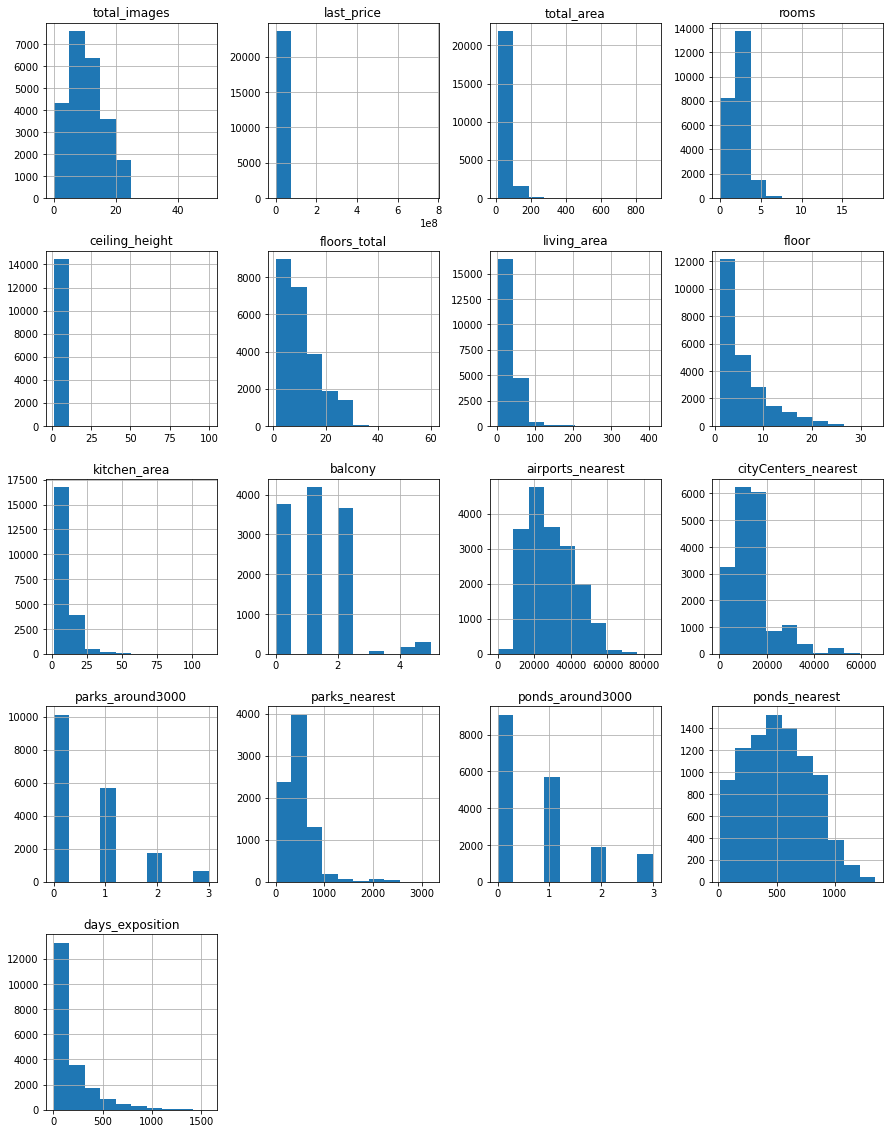

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t') 
print(df.head(10)) 
df.info() 
df.hist(figsize=(15, 20)); 

El cuadro está compuesto por 22 columnas y 23.699 filas. En las columnas "Altura de techos", "Número de pisos", "Sala de estar", "Apartamento", "Zona de cocina", "Balcones", "Nombre del asentamiento", "Distancia al aeropuerto", "Parques cerca", "Distancia al parque", "Estanque cerca", "Distancia al estanque" y "Días de alojamiento" hay valores perdidos, algunos de los cuales tenemos que procesar. 

## Vista previa de datos

#### Trabajar con saltos

In [3]:
df['balcony'].fillna(0, inplace = True) 
df['ceiling_height'].fillna(df['ceiling_height'].mean(), inplace = True)
df['is_apartment'].fillna(False, inplace = True)
df['locality_name'].fillna('Санкт-Петербург', inplace = True) 
df['parks_around3000'].fillna(0, inplace = True) 
df['ponds_around3000'].fillna(0, inplace = True)
df = df.dropna(subset=['floors_total']) 
df.isna().sum().to_frame(name="nans").query("nans > 0")["nans"] 

living_area             1870
kitchen_area            2231
airports_nearest        5532
cityCenters_nearest     5509
parks_nearest          15568
ponds_nearest          14552
days_exposition         3172
Name: nans, dtype: int64

Defina columnas con pases y su número. Rellene los espacios en blanco cuando sea posible.
Deje los valores que faltan de las columnas "Sala de estar", "Cocina", "Distancia al aeropuerto", "Distancia al centro", "Distancia al parque", "Distancia al estanque" y "Número de días de alojamiento".

La razón de las omisiones era que no era necesario rellenar todos los campos de la declaración. También pueden haber surgido problemas durante las fases de subida y subida, en caso de consultas incorrectas y/o cuando se combinan las tablas.

In [4]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

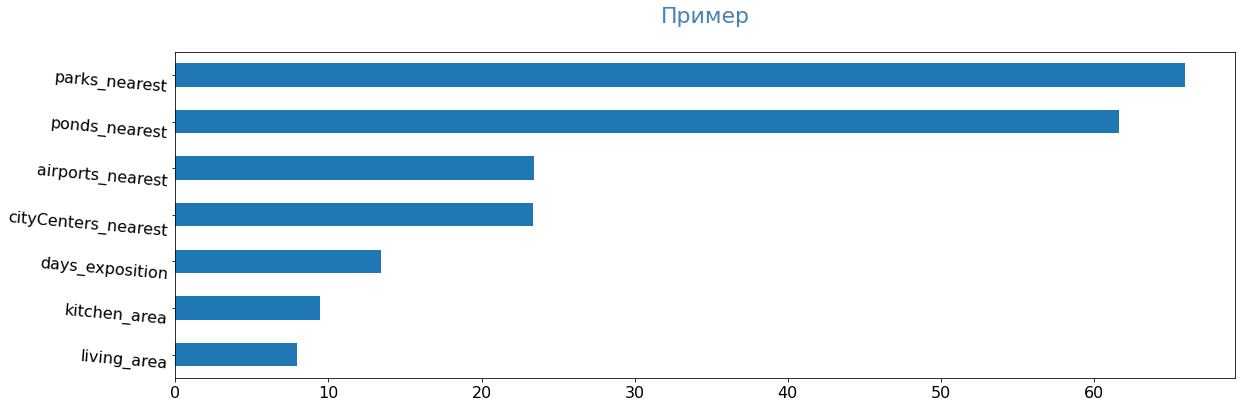

In [5]:
pass_value_barh(df)

### Cambiar los tipos de datos

In [6]:
import numpy as np
df['floors_total'] = df['floors_total'].round().astype(np.int64)
df['balcony'] = df['balcony'].round().astype(np.int64)
df['parks_around3000'] = df['parks_around3000'].round().astype(np.int64)
df['ponds_around3000'] = df['ponds_around3000'].round().astype(np.int64)
df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'])).astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  int64  
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  int64  
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

Volvamos a nuestra conclusión de información sobre la tabla y encontremos columnas donde vale la pena reemplazar los tipos de datos.
En base a las descripciones de los tipos de datos, convertimos las columnas "Número de pisos", "Balcones", "Parques cerca", "Estanques cerca" y "Días de colocación" de números reales en enteros (porque los valores en estas columnas no pueden ser números fraccionarios).
Volvamos a examinar la información de la tabla para asegurarnos de que estamos satisfechos con los tipos de datos en todas las columnas ahora.

### Trabajar con duplicados implícitos

In [7]:
df['locality_name'] = df['locality_name'].replace(
    ('деревня|посёлок|поселок|городского|типа|село|городской|коттеджный|садовое|товарищество|некоммерческое|садоводческое|при железнодорожной'), '', regex=True)
df['locality_name'] = df['locality_name'].replace('ё', 'е', regex=True) 
df['locality_name'] = df['locality_name'].str.lstrip(' ') 
print(sorted(df['locality_name'].unique())) 

['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро', 'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров', 'Бокситогорск', 'Большая Вруда', 'Большая Ижора', 'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино', 'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь', 'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово', 'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг', 'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово', 'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево', 'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово', 'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка', 'Елизаветино', 'Ефимовский', 'Жил', 'Жилгородок', 'Житково', 'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск', 'Зимитицы', 'Ивангород', 'Извара', 'Ильичево', 'Иссад', 'Калитино', 'Каложицы', 'Кальтино', 'Каменногорск', 'Камышовка', 'Каськово', 'Келози', 'Кивеннапа 

In [8]:
df['locality_name'].nunique()

306

Ahora tenemos que deshacernos de los duplicados no evidentes en la columna "Nombres de asentamientos". Imprima todos los valores únicos en la columna y ordénelos en orden alfabético para mayor comodidad. Hay muchos nombres diferentes en los datos sobre los tipos de asentamientos que realmente no necesitamos, pero no queremos encontrar los obvios. Los eliminaremos, junto con la carta de Yeo y los espacios en blanco adicionales.
El resultado es una lista de asentamientos donde nadie se repite. Solo los valores de "Gromovo" y "Gromovo station" causan duda, pero al verificar Yandex.maps, determinamos que estos son asentamientos diferentes.

In [9]:
print(df['ceiling_height'].isna().sum())

0


In [10]:
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] >= 2.5) 
for i in df['ceiling_height']:
    if i >= 25:
        df['ceiling_height'] = df['ceiling_height'].replace(i, i/10, regex=True)
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] <= 4) 
df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace = True) 
df['ceiling_height'] = round(df['ceiling_height'], 2)
df = df[df['rooms'] <= 10]
df.drop(index=df.query('last_price > 1e+08').index,inplace=True)
df.drop(index=df.query('last_price < 100000').index,inplace=True) 

### Trabajar con valores anómalos

1. Ahora compruebe los valores anómalos. En la columna "Altura de los techos" imprima todos los valores únicos y ordénelos en orden ascendente. 
2. Según las normas, la altura del techo no puede ser inferior a 2,5 m - lo más probable es que todos los valores sean menos erróneos. Los eliminaremos.
3. Es probable que los valores de 25,0, 26,0, 27,0, 27,5 y 32,0 estén mal escritos, ya que no pueden existir techos tan altos, y la coma debe situarse después del primer dígito. Sustituyamos los valores por los correctos. 
4. Ahora vamos a repetir la eliminación con el umbral superior. Según la información en fuentes abiertas, no hay apartamentos con una altura de techo de 4 m. Eliminar estos valores.
5. Para que no queden valores vacíos, rellénelos con el valor medio.
6. Queda por llevar los valores a la misma forma. No dejemos más de dos decimales.
7. Repitiendo el apartado 1 para todas las demás columnas cuantitativas, se encontró otra con valores anómalos - "Número de habitaciones". Es poco probable que haya apartamentos con más de 10 habitaciones, por lo que eliminaremos estos valores.
8. También limpiaremos los valores en la columna "Precio". Tenemos un valor de menos de 100 mil. rub. - claramente hay algo mal con él. También quitamos el "demasiado caro" 37 valores por encima de 100 millones de rublos.

In [11]:
data = df.copy()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23568 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23568 non-null  int64  
 1   last_price            23568 non-null  float64
 2   total_area            23568 non-null  float64
 3   first_day_exposition  23568 non-null  object 
 4   rooms                 23568 non-null  int64  
 5   ceiling_height        23568 non-null  float64
 6   floors_total          23568 non-null  int64  
 7   living_area           21703 non-null  float64
 8   floor                 23568 non-null  int64  
 9   is_apartment          23568 non-null  bool   
 10  studio                23568 non-null  bool   
 11  open_plan             23568 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23568 non-null  int64  
 14  locality_name         23568 non-null  object 
 15  airports_nearest   

In [13]:

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,568.00","23,568.00","23,568.00","20,402.00","23,568.00","21,703.00","21,343.00","23,568.00","23,568.00"
min,0.00,12.00,2.50,1.00,"430,000.00",2.00,1.30,1.00,1.00
max,10.00,517.00,4.00,"1,580.00","99,000,000.00",347.50,107.00,33.00,60.00


Tratemos de construir histogramas a partir de estas columnas para identificar anomalías y rarezas.

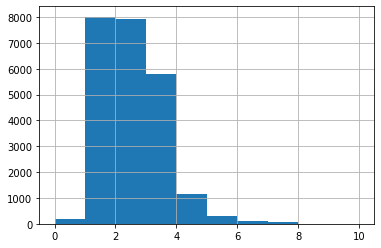

In [14]:
df['rooms'].hist(bins=10);

De hecho, hay más de 7 habitaciones muy pocos apartamentos, ni siquiera visible en el gráfico, si se mira. Voy a eliminarlos.

In [15]:
df = df[df['rooms'] <= 7] 

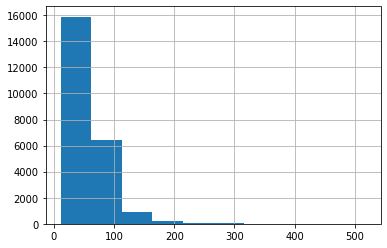

In [16]:
df['total_area'].hist(bins=10);

Eliminar los valores de la zona de apartamentos de más de 300 metros cuadrados. m y menos de 20 metros cuadrados. m

In [17]:
df = df[df['total_area'] <= 300]
df = df[df['total_area'] >= 20] 

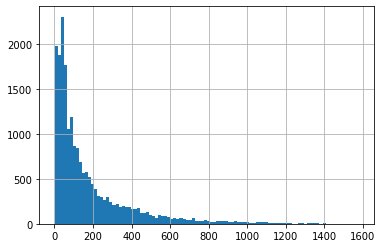

In [18]:
df['days_exposition'].hist(bins=100);

Vamos a tratar de descartar los anuncios que cuelgan más de tres años. Son relativamente pocos, y parece que con los anuncios que han estado colgando durante tanto tiempo algo está mal.

In [19]:
df.drop(index=df.query('days_exposition > 365*3 & days_exposition != None').index,inplace=True)


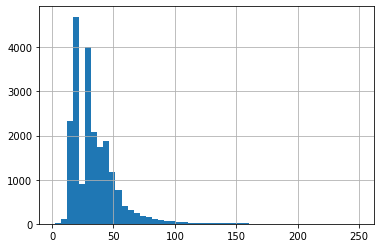

In [20]:
df['living_area'].hist(bins=50);

Aquí voy a tratar de descartar los valores de la zona de vida de más de 160 y menos de 10 - tan pequeño no debe ser.

#### check nan

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23322 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23322 non-null  int64  
 1   last_price            23322 non-null  float64
 2   total_area            23322 non-null  float64
 3   first_day_exposition  23322 non-null  object 
 4   rooms                 23322 non-null  int64  
 5   ceiling_height        23322 non-null  float64
 6   floors_total          23322 non-null  int64  
 7   living_area           21487 non-null  float64
 8   floor                 23322 non-null  int64  
 9   is_apartment          23322 non-null  bool   
 10  studio                23322 non-null  bool   
 11  open_plan             23322 non-null  bool   
 12  kitchen_area          21139 non-null  float64
 13  balcony               23322 non-null  int64  
 14  locality_name         23322 non-null  object 
 15  airports_nearest   

In [22]:
df.drop(index=df.query('10 < living_area < 160 & living_area == None').index,inplace=True)

In [23]:
# check
df.shape[0]

23322

Los saltos se dividen en tres columnas: 'days_exposition',  'living_área',  'kitchen_área'. Añadido a los términos ignorar los saltos.

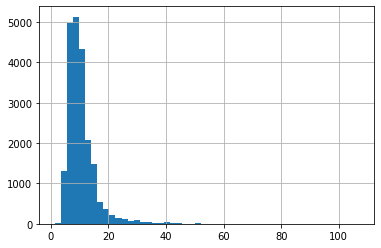

In [24]:
df['kitchen_area'].hist(bins=50);

Desecharemos los valores de la zona de cocina por encima de 50 y por debajo de 2.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23322 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23322 non-null  int64  
 1   last_price            23322 non-null  float64
 2   total_area            23322 non-null  float64
 3   first_day_exposition  23322 non-null  object 
 4   rooms                 23322 non-null  int64  
 5   ceiling_height        23322 non-null  float64
 6   floors_total          23322 non-null  int64  
 7   living_area           21487 non-null  float64
 8   floor                 23322 non-null  int64  
 9   is_apartment          23322 non-null  bool   
 10  studio                23322 non-null  bool   
 11  open_plan             23322 non-null  bool   
 12  kitchen_area          21139 non-null  float64
 13  balcony               23322 non-null  int64  
 14  locality_name         23322 non-null  object 
 15  airports_nearest   

In [26]:
df.drop(index=df.query('2 < kitchen_area < 50 & living_area == None').index,inplace=True)

In [27]:
df.shape[0]

23322

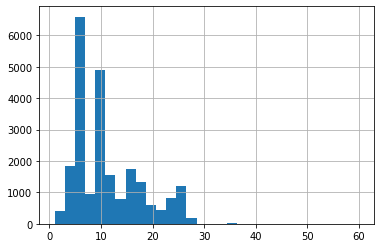

In [28]:
df['floors_total'].hist(bins=30);

Vamos a descartar los valores de los apartamentos, ubicados en edificios de más de 30 pisos - son extremadamente pequeños.

In [29]:
df = df[df['floors_total'] <= 30]

In [30]:
df.shape[0]

23290

In [31]:
data.rooms.value_counts().to_frame()

,rooms
1,8015
2,7911
3,5791
4,1168
5,315
0,194
6,99
7,54
8,10
9,8


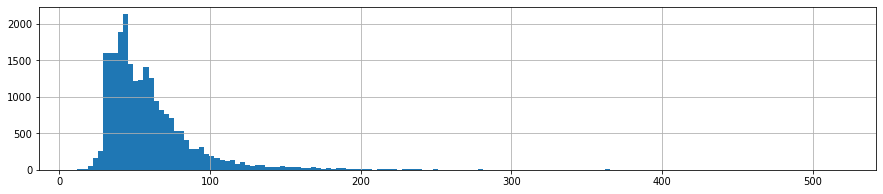

In [32]:
data.total_area.hist(bins = 150, figsize = (15,3));

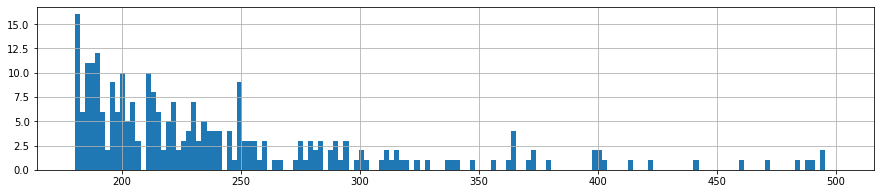

In [33]:
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

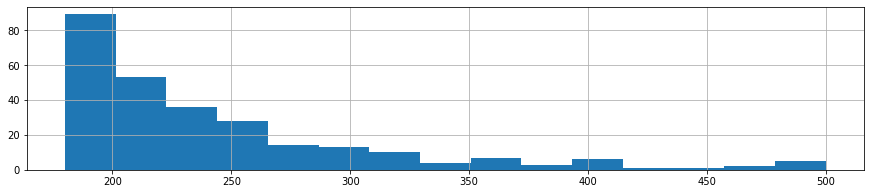

In [34]:
data.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

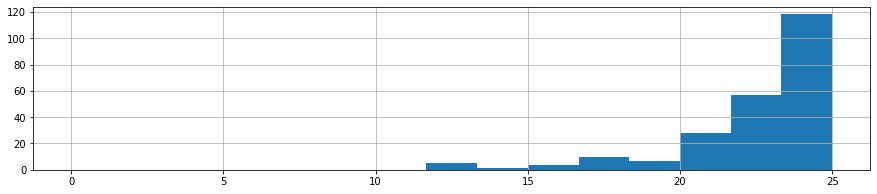

In [35]:
data.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [36]:


(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.00,2.50,3.00,"569,206.00",10.00,3.80,1.00,2.00
0.01,1.00,25.32,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.5,2.00,52.00,2.77,95.00,"4,625,770.00",30.00,9.10,4.00,9.00
0.99,5.00,187.37,3.50,"1,065.99","33,443,184.00",112.00,35.00,23.00,26.00
0.9988,7.00,341.05,4.00,"1,370.59","76,954,294.80",189.97,55.58,26.00,35.00


In [37]:


(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,290.00","23,290.00","23,290.00","20,145.00","23,290.00","21,456.00","21,110.00","23,290.00","23,290.00"
min,0.00,20.00,2.50,1.00,"430,000.00",2.00,1.30,1.00,1.00
max,7.00,300.00,4.00,"1,095.00","99,000,000.00",250.00,107.00,27.00,29.00


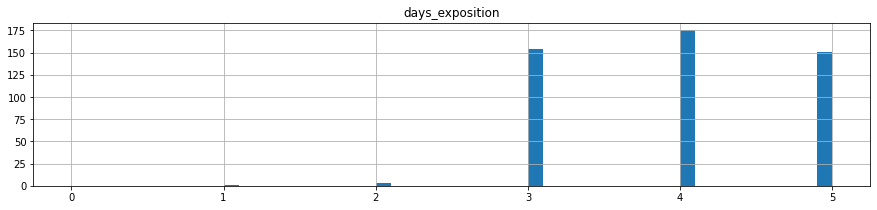

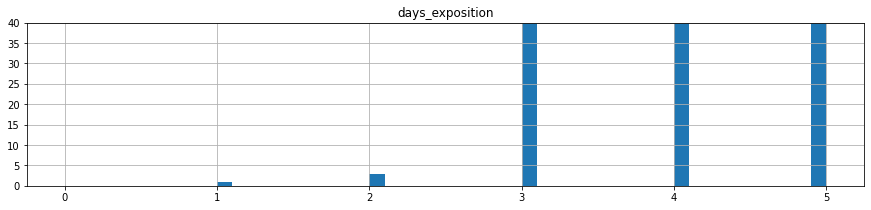

In [38]:
df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));
df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

#### check nan

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23290 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23290 non-null  int64  
 1   last_price            23290 non-null  float64
 2   total_area            23290 non-null  float64
 3   first_day_exposition  23290 non-null  object 
 4   rooms                 23290 non-null  int64  
 5   ceiling_height        23290 non-null  float64
 6   floors_total          23290 non-null  int64  
 7   living_area           21456 non-null  float64
 8   floor                 23290 non-null  int64  
 9   is_apartment          23290 non-null  bool   
 10  studio                23290 non-null  bool   
 11  open_plan             23290 non-null  bool   
 12  kitchen_area          21110 non-null  float64
 13  balcony               23290 non-null  int64  
 14  locality_name         23290 non-null  object 
 15  airports_nearest   

In [40]:
df = df[df['days_exposition'] >= 3]

In [41]:
df.shape[0]

20141

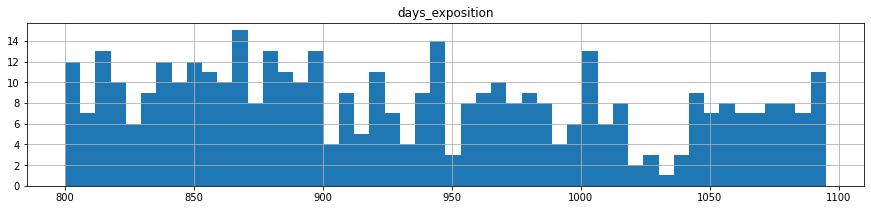

In [42]:
df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (800,1095));

Eliminar valores inferiores a 3 días. No se encuentran colas en el borde superior, dejar.

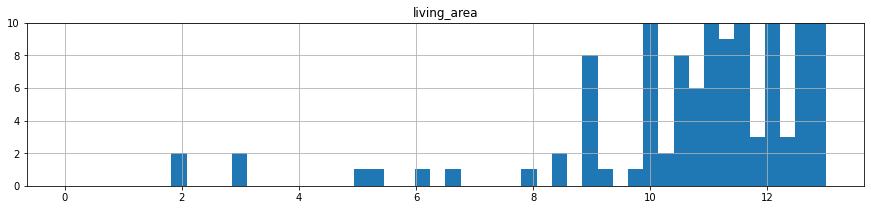

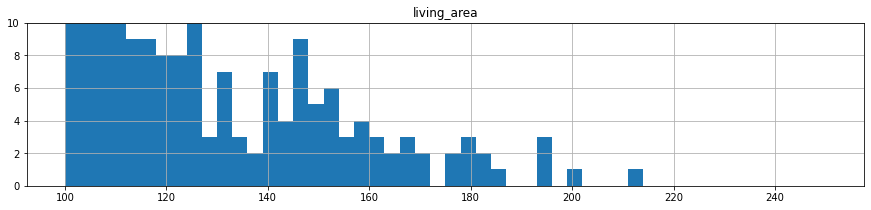

In [43]:
# check
df.hist(column = 'living_area', bins = 50, figsize = (15,3), range = (0,13));
plt.ylim(0, 10);
df.hist(column = 'living_area', bins = 50, figsize = (15,3), range = (100,250));
plt.ylim(0, 10);

In [44]:
df = df[df['living_area'] >= 9]
df = df[df['living_area'] < 200]

In [45]:
df.shape[0]

18482

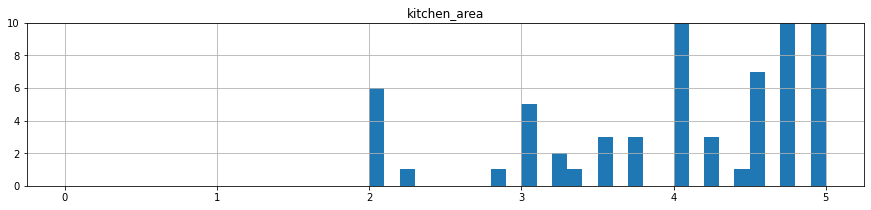

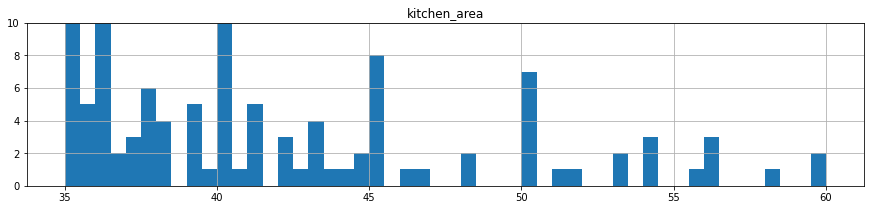

In [46]:
df.hist(column = 'kitchen_area', bins = 50, figsize = (15,3), range = (0,5));
plt.ylim(0, 10);
df.hist(column = 'kitchen_area', bins = 50, figsize = (15,3), range = (35,60));
plt.ylim(0, 10);

In [47]:
df = df[df['kitchen_area'] >= 2]
df = df[df['kitchen_area'] <= 50]

In [48]:
df.shape[0]

17771

In [49]:


(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"17,771.00","17,771.00","17,771.00","17,771.00","17,771.00","17,771.00","17,771.00","17,771.00","17,771.00"
min,1.00,20.00,2.50,3.00,"450,000.00",9.00,2.00,1.00,1.00
max,7.00,300.00,4.00,"1,095.00","95,000,000.00",195.00,50.00,27.00,29.00


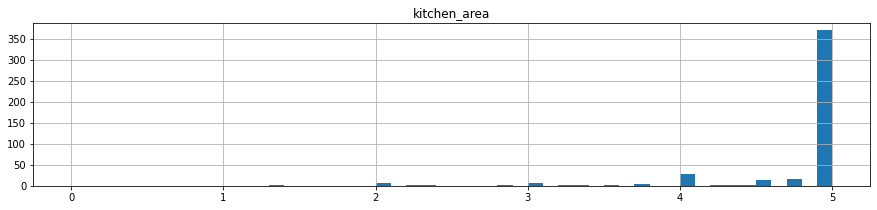

In [50]:
data.hist(column = 'kitchen_area', bins = 50, figsize = (15,3), range = (0,5));

## Adición de nuevas columnas a la tabla

**Precio de un metro cuadrado:**

In [51]:
df['1mprice'] = round(df['last_price'] / df['total_area'], 2) # добавим столбец с ценой за 1 км^2

**Día de la semana del anuncio (0 - lunes, 1 - martes y así sucesivamente):**

In [52]:
df['weekday'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d %H:%M').dt.dayofweek

**Mes de publicación del anuncio:**

In [53]:
df['month'] = pd.to_datetime(df['first_day_exposition']).dt.month

**año de publicación del anuncio:**

In [54]:
df['year'] = pd.to_datetime(df['first_day_exposition']).dt.year

**tipo de piso (valores - «first», «last», «other»):***

In [55]:
print(sorted(df['floors_total'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [56]:
def floortype(row):
    if row['floors_total'] == row['floor'] and row['floors_total'] != 1:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'
df['floor_type'] = df.apply(floortype, axis=1)

**distancia al centro de la ciudad en kilómetros (traducir de m en km y redondear a valores enteros):**

In [57]:
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest'] / 1000)

## Análisis de datos de investigación


In [58]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1mprice,weekday,month,year,cityCenters_nearest_km
count,17771.000000,1.777100e+04,17771.000000,17771.000000,17771.000000,17771.000000,17771.000000,17771.000000,17771.000000,17771.000000,...,17771.000000,6073.000000,17771.000000,6802.000000,17771.000000,17771.000000,17771.000000,17771.000000,17771.000000,13921.000000
mean,9.824714,5.835920e+06,57.755411,2.024534,2.733359,10.732317,32.965110,5.926003,10.175767,0.627764,...,0.466040,488.809485,0.582128,526.729932,176.200270,96814.628341,2.564234,6.621912,2017.214451,14.386323
std,5.650369,5.287991e+06,27.304516,0.975943,0.191784,6.507714,18.062632,4.845966,4.770211,0.963506,...,0.741193,339.024102,0.872350,276.358489,199.434536,38779.524254,1.776312,3.453010,0.948349,8.586018
min,0.000000,4.500000e+05,20.000000,1.000000,2.500000,1.000000,9.000000,1.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,13.000000,3.000000,9615.380000,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.450000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.000000,0.000000,...,0.000000,287.000000,0.000000,307.000000,44.000000,76666.670000,1.000000,3.000000,2017.000000,10.000000
50%,9.000000,4.550000e+06,51.000000,2.000000,2.770000,9.000000,30.000000,4.000000,9.000000,0.000000,...,0.000000,452.000000,0.000000,513.000000,100.000000,93783.780000,3.000000,7.000000,2017.000000,13.000000
75%,14.000000,6.490000e+06,67.300000,3.000000,2.770000,16.000000,41.300000,8.000000,11.600000,1.000000,...,1.000000,613.000000,1.000000,737.000000,232.000000,111449.830000,4.000000,10.000000,2018.000000,16.000000
max,50.000000,9.500000e+07,300.000000,7.000000,4.000000,29.000000,195.000000,27.000000,50.000000,5.000000,...,3.000000,3190.000000,3.000000,1344.000000,1095.000000,719298.250000,6.000000,12.000000,2019.000000,65.000000


### Estudiar la configuración del objeto

Estudiaremos los parámetros de los objetos construyendo histogramas separados para cada uno de los parámetros.

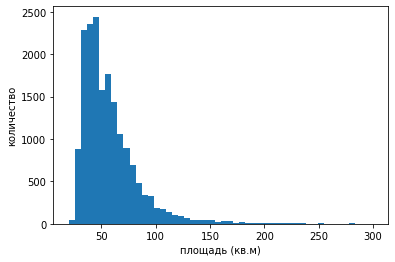

In [59]:
fig, ax = plt.subplots()
plt.xlabel('площадь (кв.м)')
plt.ylabel('количество')
ax.hist(df['total_area'], bins=50); 
plt.show()

Los apartamentos por encima de 100m2 son pequeños, y por encima de 200m2 - muy pequeño, muy pequeño número del total. Probablemente es una propiedad de élite. La mayoría de los apartamentos tienen una superficie de unos 50m2.

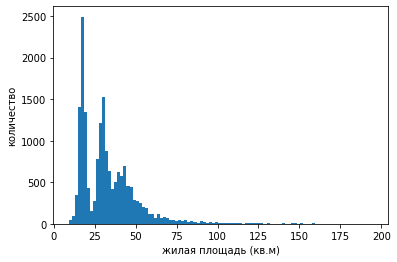

In [60]:
fig, ax = plt.subplots()
plt.xlabel('жилая площадь (кв.м)')
plt.ylabel('количество')
ax.hist(df['living_area'], bins=100);

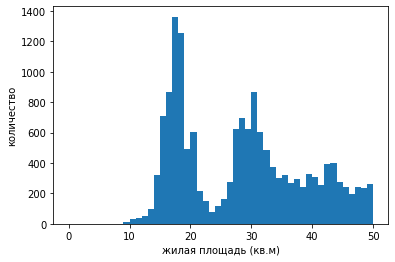

In [61]:
fig, ax = plt.subplots()
plt.xlabel('жилая площадь (кв.м)')
plt.ylabel('количество')
ax.hist(df['living_area'], bins=50, range=(0,50));

En cuanto a la superficie habitable, vemos dos picos: unos 18m2 y 31m2. Fallo sospechoso en 24m2.

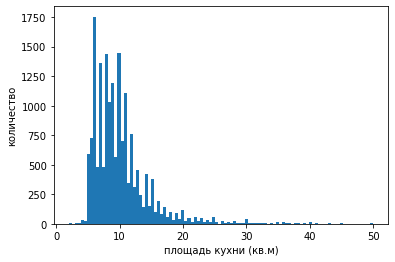

In [62]:
fig, ax = plt.subplots()
plt.xlabel('площадь кухни (кв.м)')
plt.ylabel('количество')
ax.hist(df['kitchen_area'], bins=100);

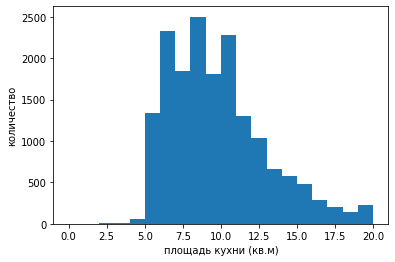

In [63]:
fig, ax = plt.subplots()
plt.xlabel('площадь кухни (кв.м)')
plt.ylabel('количество')
ax.hist(df['kitchen_area'], bins=20, range=(0,20));

El área de las cocinas se distribuye de manera uniforme. Hay pequeñas ventajas de los espacios pares: 6, 8 y 10 - ¿un buen presagio? )

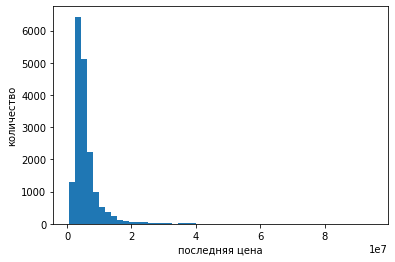

In [64]:
fig, ax = plt.subplots()
plt.xlabel('последняя цена')
plt.ylabel('количество')
ax.hist(df['last_price'], bins=50);

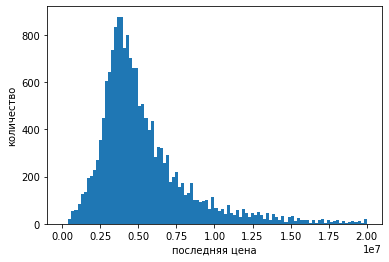

In [65]:
fig, ax = plt.subplots()
plt.xlabel('последняя цена')
plt.ylabel('количество')
ax.hist(df['last_price'], bins=100, range=(0,2e+07));

A precios esperados dispersión. En la vivienda minoría de élite.

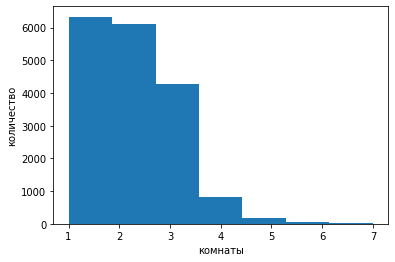

In [66]:
fig, ax = plt.subplots()
plt.xlabel('комнаты')
plt.ylabel('количество')
ax.hist(df['rooms'], bins=df['rooms'].max());

La mayoría de todos los apartamentos de 1 y 2 habitaciones.

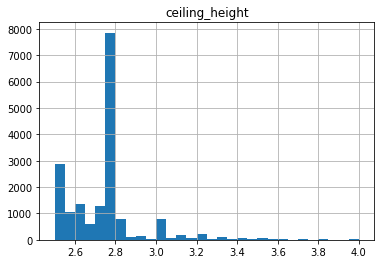

In [67]:
df.hist('ceiling_height', bins=30);

Una clara ventaja para los apartamentos con una altura de techo de 2,8 m 2.

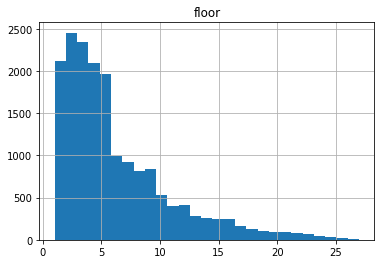

In [68]:
df.hist('floor', bins=df['floor'].max());

El mayor número de apartamentos se encuentra en el segundo piso. En general, la mayoría de los apartamentos se encuentran no más de 6 pisos.

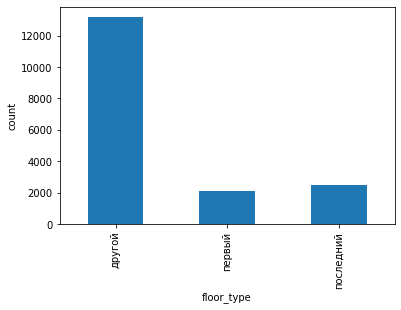

In [69]:
df.groupby(by='floor_type')['floor_type'].count().plot(kind='bar', ylabel = 'count');

Obviamente, la mayoría de los apartamentos no están en la primera y no en los últimos pisos.

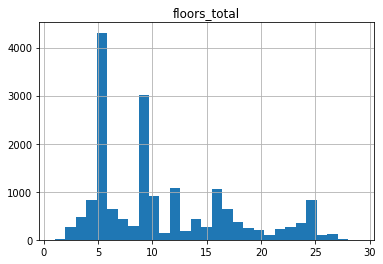

In [70]:
df.hist('floors_total', bins=df['floors_total'].max());

En Petersburgo, como en muchas otras ciudades rusas, el mayor número de cinco y nueve pisos.

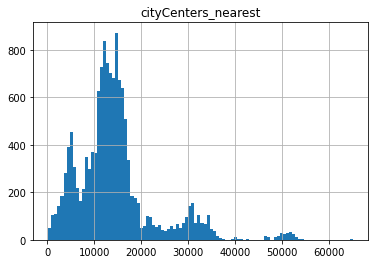

In [71]:
df.hist('cityCenters_nearest', bins=100);

Los dos valores más notables son 11 y 15 km al centro.

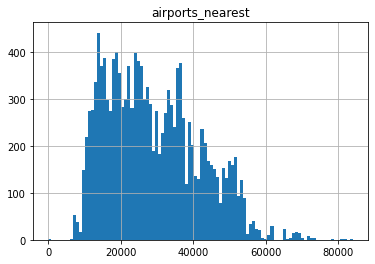

In [72]:
df.hist('airports_nearest', bins=100);

El gráfico es bastante ruidoso, no hay valores atípicos.

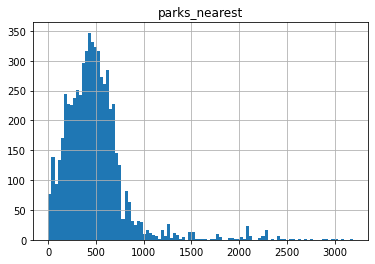

In [73]:
df.hist('parks_nearest', bins=100);

La mayoría de los apartamentos están situados a unos 500 m del parque.

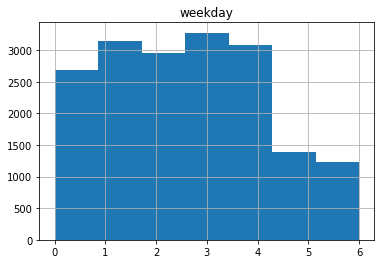

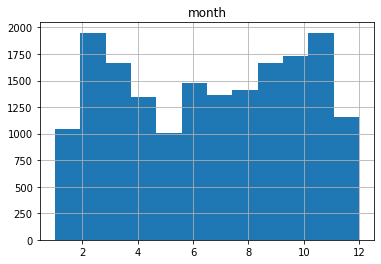

In [74]:
df.hist('weekday', bins=7);
df.hist('month', bins=12);

La mayoría de los apartamentos están en exhibición entre semana, los fines de semana hay una disminución de la actividad en más de la mitad.
Los meses son los más activos de febrero a abril, seguidos de una fuerte caída en mayo, y luego un aumento gradual, que continúa hasta noviembre. En diciembre la gente ya no está para los apartamentos, el número de anuncios se redujo de nuevo.

Veamos qué tan rápido se vendieron los apartamentos.

### Estudio de la tasa de venta de apartamentos

Среднее время продажи квартиры в днях: 176
Медианное время продажи квартиры в днях: 100

[Выбросы] Количество объявлений, которые сняты через:
45 дней: 517
60 дней: 339
90 дней: 134


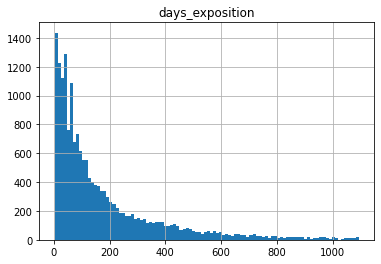

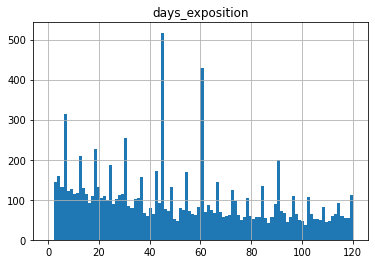

In [75]:
df.hist('days_exposition', bins=100);
df.hist('days_exposition', bins=100, range = (0,120));
print(f'Среднее время продажи квартиры в днях:',int(df['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(df['days_exposition'].median()))

print('\n[Выбросы] Количество объявлений, которые сняты через:')
print('45 дней:',df[df['days_exposition']==45]['days_exposition'].count())
print('60 дней:',df[df['days_exposition']==60]['days_exposition'].count())
print('90 дней:',df[df['days_exposition']==90]['days_exposition'].count())

Las emisiones están excesivamente aisladas y probablemente dependen del modo de funcionamiento del sitio, que después de 45, 60 y 90 días el anuncio en sí se retira de la venta. Sobre la base de los valores medio y mediano, se puede suponer que los anuncios completados hasta 95 días pueden considerarse rápidos y de más de 180 días de duración.

### Estudio de los factores que influyen en el precio

Estudiemos la dependencia de los precios en 
- superficie total;
- espacio vital;
- cocina;
- el número de habitaciones;
- el piso en el que se encuentra el apartamento (primero, último, otro);
- fechas de alojamiento (semana, mes, año).

In [76]:
df.loc[df['floor_type'] == 'первый', 'floor_type_idx'] = 1
df.loc[df['floor_type'] == 'другой', 'floor_type_idx'] = 2
df.loc[df['floor_type'] == 'последний', 'floor_type_idx'] = 3

In [77]:
graphs = ['total_area',
          'living_area',
          'kitchen_area',
          'rooms',
          'floor_type_idx',
          'weekday',
          'month',
          'year']

for iter in graphs:
    correlation = df['last_price'].corr(df[iter])
    print(f'Корреляция между last_price и {iter} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 74.69%
Корреляция между last_price и living_area составляет: 64.97%
Корреляция между last_price и kitchen_area составляет: 54.07%
Корреляция между last_price и rooms составляет: 46.18%
Корреляция между last_price и floor_type_idx составляет: 5.81%
Корреляция между last_price и weekday составляет: 0.04%
Корреляция между last_price и month составляет: 1.24%
Корреляция между last_price и year составляет: -6.56%


Vemos la relación más tangible entre el precio y el área de apartamentos (general, residencial y cocina). Construimos gráficos de correlación para estas dependencias.

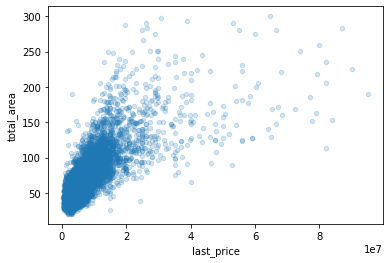

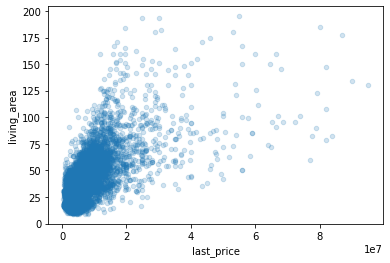

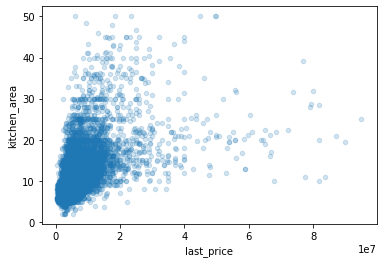

In [78]:
df.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2);
df.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2);
df.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2);

Cree gráficos de dependencias para otras columnas. Dependencia del número de salas:

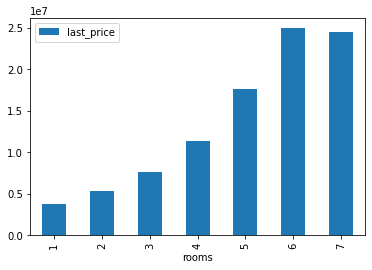

In [79]:
df.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');

El precio más alto para apartamentos de 9 habitaciones. Pero apartamentos de 10 habitaciones por alguna razón son más baratos que 8 habitaciones.

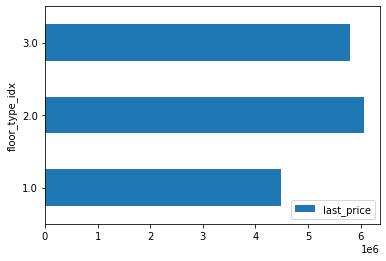

In [80]:
df.pivot_table(index='floor_type_idx',values='last_price').plot(y='last_price', kind='barh');

El precio de los apartamentos situados en la primera planta es un poco más bajo. Los apartamentos en otras plantas no son prácticamente diferentes en valor.

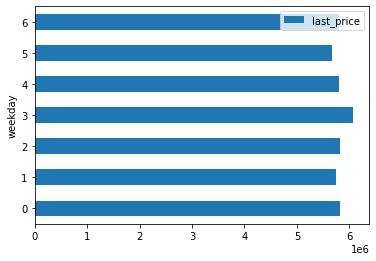

In [81]:
df.pivot_table(index='weekday',values='last_price').plot(y='last_price', kind='barh'); # построим график зависимости по дням недели

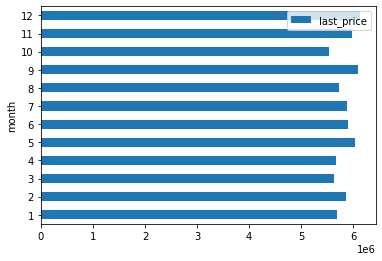

In [82]:
df.pivot_table(index='month',values='last_price').plot(y='last_price', kind='barh'); # построим график зависимости по месяцам

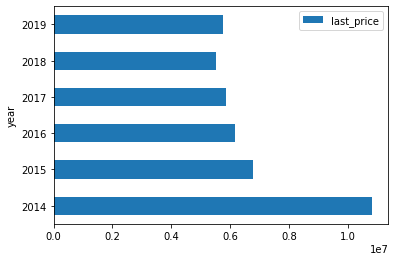

In [83]:
df.pivot_table(index='year',values='last_price').plot(y='last_price', kind='barh'); # построим график зависимости по годам

Sobre la base de estos gráficos vemos que el precio no depende del día de la semana y el mes. Dependencia del año hay - los apartamentos más caros fueron en 2014, entonces hay una tendencia a bajar los precios, hasta 2019, cuando el precio creció.

Vamos a calcular el número de anuncios por año y ver que los anuncios para 2014. No se pueden tener en cuenta al elaborar la conclusión.  

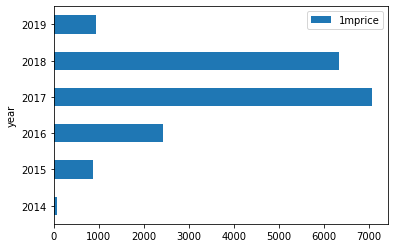

In [84]:
df.groupby(['year'])[['1mprice']].count().plot(y='1mprice', kind='barh');

Construiremos un precio de histograma de 1 m2. metros por años y veremos que el precio de 2015 a 2018 fluctuó ligeramente, y en 2019 hubo un aumento significativo en el precio.

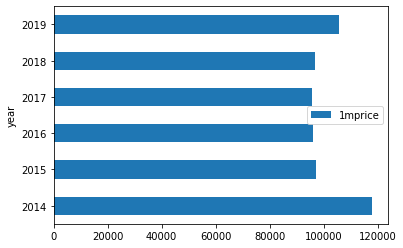

In [85]:
df.pivot_table(index='year',values='1mprice').plot(y='1mprice', kind='barh'); # построим график зависимости по годам

### Top 10 ciudades por número de anuncios

Selecciona 10 ubicaciones con más anuncios. 

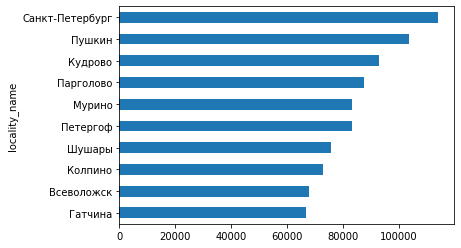

In [86]:
top_10 = df.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count']) # сохраним сводную таблицу со значениями цены и общей площади
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count'] # укажем столбцы, по которым будем группировать
top_10.pop('total_area_count') # удалим лишние элементы
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True) # отсортируем значения по цене
top_10 = top_10.iloc[:10] # оставим 10 максимальных
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum'] # посчитаем цену за квадратный метр
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True) # отсортируем значения
top_10['price_per_sq_m'].plot(kind='barh'); # построим гистограмму

Vemos que la vivienda más cara en St. Petersburg, a continuación, ir a sus ciudades satélite.

### Dependencia del precio de la distancia al centro de la ciudad

Construiremos un histograma de dependencia de precios desde la distancia al centro de la ciudad en km2.

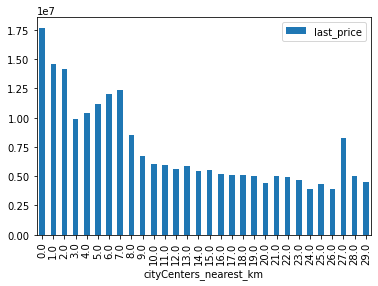

In [87]:
(
    df[df['locality_name']=='Санкт-Петербург']
    .pivot_table(
        index='cityCenters_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
);

Vemos los precios máximos a una distancia de hasta 1 km del centro. En general, los precios altos a una distancia de 1 a 8 km, luego comienza a disminuir. A una distancia de 27 km se puede ver una oleada, tal vez hay alguna zona de élite. 

In [88]:
df.query("cityCenters_nearest_km == 27 & locality_name == 'Санкт-Петербург'").sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,1mprice,weekday,month,year,floor_type,cityCenters_nearest_km,floor_type_idx
5961,6,2250000.0,32.0,2018-02-27T00:00:00,1,2.77,2,16.5,2,False,...,0,NaN,178,70312.50,1,2,2018,последний,27.0,3.0
748,13,14350000.0,74.0,2017-11-28T00:00:00,2,3.13,5,30.0,3,False,...,0,NaN,128,193918.92,1,11,2017,другой,27.0,2.0


Hemos sido capaces de encontrar solo dos valores, por lo que al parecer hay una anomalía. Porque. son muy pocos, los eliminaremos de los índices. 

In [89]:
df = df.drop(index=[5961, 748])

Vemos grandes emisiones de valores extremos. En este kilómetro hay un fuerte aumento en el precio. 

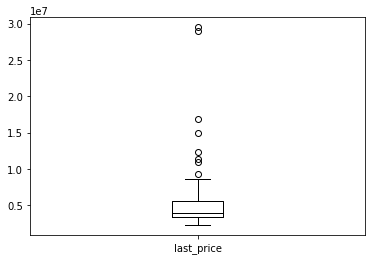

In [90]:
df.query('cityCenters_nearest_km == 27').boxplot(column=['last_price'], grid= False , color='black')
plt.show()

In [91]:
df.query('cityCenters_nearest_km == 3').sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,1mprice,weekday,month,year,floor_type,cityCenters_nearest_km,floor_type_idx
10287,5,2800000.0,31.0,2018-01-15T00:00:00,1,2.60,5,16.0,1,False,...,1,869.0,62,90322.58,0,1,2018,первый,3.0,1.0
3719,8,3100000.0,48.8,2017-05-12T00:00:00,1,2.77,6,28.9,1,False,...,3,155.0,80,63524.59,4,5,2017,первый,3.0,1.0
18572,0,3890000.0,36.0,2017-08-24T00:00:00,1,2.77,4,19.0,1,False,...,1,491.0,281,108055.56,3,8,2017,первый,3.0,1.0
9637,9,3990900.0,40.0,2017-09-05T00:00:00,1,2.60,4,21.5,1,False,...,3,300.0,491,99772.50,1,9,2017,первый,3.0,1.0
5406,6,3999000.0,38.0,2017-08-16T00:00:00,2,3.30,5,22.0,1,False,...,3,52.0,160,105236.84,2,8,2017,первый,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,4,30000000.0,251.0,2017-07-27T00:00:00,7,3.50,5,193.0,4,False,...,1,802.0,613,119521.91,3,7,2017,другой,3.0,2.0
23091,20,33000000.0,186.0,2017-10-11T00:00:00,3,3.00,5,130.0,3,False,...,0,NaN,138,177419.35,2,10,2017,другой,3.0,2.0
7136,0,48000000.0,108.0,2018-02-01T00:00:00,3,2.77,5,61.0,2,False,...,3,415.0,144,444444.44,3,2,2018,другой,3.0,2.0
6462,2,82000000.0,114.0,2015-12-17T00:00:00,3,2.77,5,78.5,4,False,...,3,69.0,651,719298.25,3,12,2015,другой,3.0,2.0


Vemos en el quinto kilómetro entre los apartamentos más baratos de 5 y 4 habitaciones con una gran área, por lo que el precio es de 1 metro cuadrado. se está volviendo significativamente más bajo. Parece que tales apartamentos baratos no pueden ser y estos precios son incorrectos, o fraudulentos.

In [92]:
df.query('cityCenters_nearest_km == 5').sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,1mprice,weekday,month,year,floor_type,cityCenters_nearest_km,floor_type_idx
17753,12,1800000.0,117.3,2016-02-18T00:00:00,5,2.77,4,23.60,2,False,...,0,NaN,139,15345.27,3,2,2016,другой,5.0,2.0
13739,19,2100000.0,80.0,2016-07-01T00:00:00,4,2.77,6,23.00,3,False,...,1,705.0,23,26250.00,4,7,2016,другой,5.0,2.0
6544,4,2740000.0,20.3,2018-12-18T00:00:00,1,3.00,6,16.00,1,False,...,1,1018.0,29,134975.37,1,12,2018,первый,5.0,1.0
3883,3,2800000.0,31.5,2018-03-06T00:00:00,2,3.40,5,23.90,1,False,...,1,199.0,13,88888.89,1,3,2018,первый,5.0,1.0
8873,6,2950000.0,20.0,2016-06-18T00:00:00,1,2.77,7,14.00,1,False,...,0,NaN,38,147500.00,5,6,2016,первый,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,20,54000000.0,145.9,2017-08-23T00:00:00,3,2.85,20,83.80,13,False,...,2,444.0,335,370116.52,2,8,2017,другой,5.0,2.0
6728,10,55000000.0,280.0,2018-03-22T00:00:00,7,2.77,6,195.00,5,False,...,2,594.0,406,196428.57,3,3,2018,другой,5.0,2.0
18633,12,55900000.0,222.0,2018-11-16T00:00:00,5,3.76,5,167.00,1,False,...,0,NaN,8,251801.80,4,11,2018,первый,5.0,1.0
14946,1,56000000.0,231.6,2017-05-05T00:00:00,5,3.49,6,150.40,3,False,...,1,200.0,533,241796.20,4,5,2017,другой,5.0,2.0


## Conclusión general

Se estudiaron datos sobre anuncios de venta de apartamentos en San Petersburgo y Lensk de 2014 a 2019. En la tabla había valores perdidos, algunos de los cuales nos deshicimos con seguridad, así como emisiones claras que impiden una representación objetiva.

El TOP-10 incluye principalmente las ciudades más cercanas a San Petersburgo y las ciudades más grandes de la región:
- Pushkin;
- Gatchina;
- Vsevolodysk;
- Vyborg.

Los precios de los apartamentos dependen principalmente de la zona y la distancia desde el centro. A 27 km hay un fuerte aumento en el precio. Al estudiar el mapa, se reveló que a esta distancia es Peterhof - una de las principales atracciones turísticas de Rusia. Es posible que los apartamentos caros estén justo al lado de él. El piso y el piso casi no afecta el precio, a menos que, por supuesto, es el primero - en este caso, el apartamento será más barato.
Excluiremos de la conclusión del anuncio para 2014, porque son pequeños del número total. Vemos que el precio de 2015 a 2018 estaba aproximadamente al mismo nivel, y en 2019 el precio comenzó a subir significativamente.

Las ventas rápidas son de hasta 95 días, e inusualmente largas - más de 180 días.
Número de anuncios que se eliminan a través de:
45 días: 879
60 días: 538
90 días: 201
Los datos probablemente se toman de un sitio donde los anuncios inactivos se eliminan automáticamente si el usuario no extiende el tiempo de colocación después de un período determinado, o la presencia de un programa de pago. Necesitamos contactar al proveedor de datos.

### Bonus - Diagrama de dispersión

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

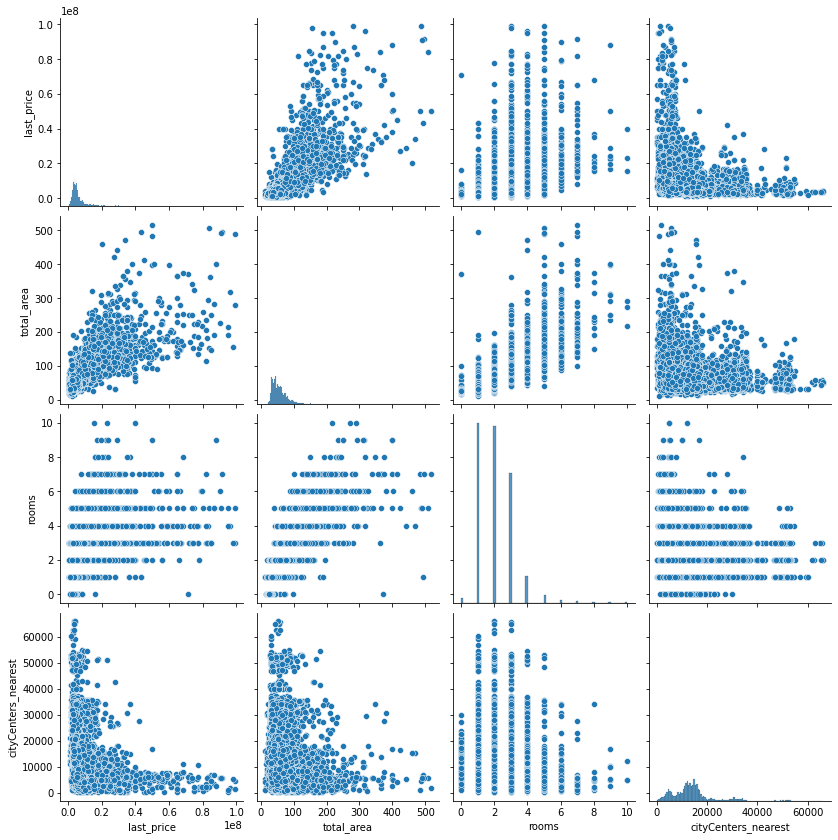

In [94]:
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


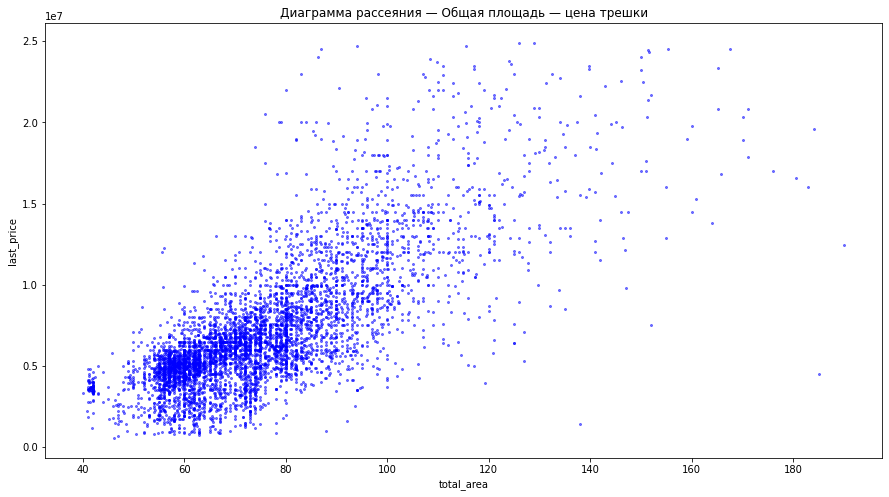

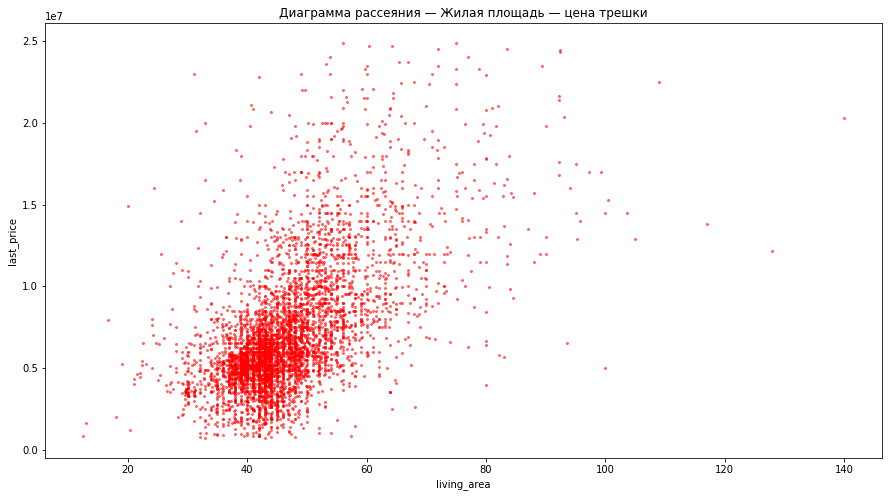

In [95]:
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

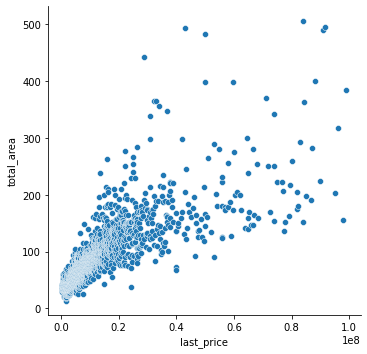

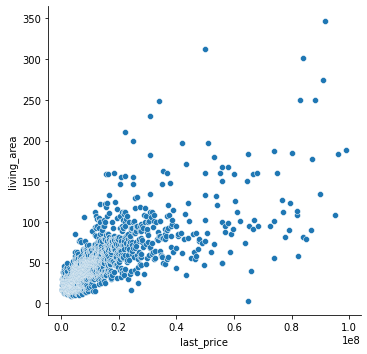

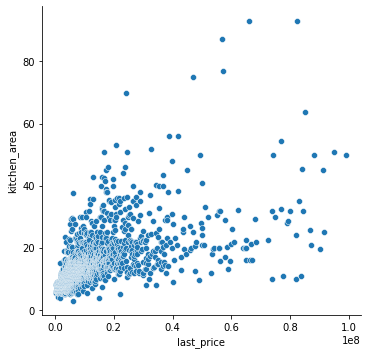

In [96]:
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')